In [1]:
# Import necessary libraries for data loading, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set a plotting style (optional)
plt.style.use('seaborn-v0_8-whitegrid')
# Ensure plots appear inline in the notebook
%matplotlib inline

print("Libraries imported.")

Libraries imported.


In [2]:
# --- Load the CSV Data ---
csv_file_path = os.path.join('results', 'metrics.csv') # Construct path relative to notebook
print(f"\nAttempting to load data from: {csv_file_path}")

try:
    # Load the data into a pandas DataFrame
    df = pd.read_csv(csv_file_path)
    print("Successfully loaded data.")

    # --- Print Basic Information about the DataFrame ---

    # (1) Shape (rows, columns)
    print(f"\nDataFrame shape: {df.shape}")

    # (2) Column names and non-null counts / data types
    print("\nColumns and Data Types / Non-Null Counts:")
    df.info()

    # (3) Number of null values per column
    print("\nNull values per column:")
    print(df.isnull().sum())

    # (4) Basic descriptive statistics for numeric columns (count, mean, std, min, max, quartiles)
    # This will give min/max for raw_length, bit_length, and is_correct
    print("\nDescriptive statistics for numeric columns:")
    # Include 'all' to try and get stats for non-numeric too, though describe() focuses on numeric
    print(df.describe(include='all')) 

    # (5) Display the first few rows to see the actual data
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())

except FileNotFoundError:
    print(f"\nERROR: File not found at {csv_file_path}")
    print("Please ensure the 'metrics.csv' file exists in the 'results' directory relative to the notebook.")
except Exception as e:
    print(f"\nAn error occurred during loading or inspection: {e}")


Attempting to load data from: results/metrics.csv
Successfully loaded data.

DataFrame shape: (101376, 6)

Columns and Data Types / Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101376 entries, 0 to 101375
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   uid               101376 non-null  object 
 1   response_index    101376 non-null  int64  
 2   is_correct        101375 non-null  float64
 3   raw_length        101376 non-null  int64  
 4   bit_length        101375 non-null  float64
 5   code_parse_error  101376 non-null  bool   
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 4.0+ MB

Null values per column:
uid                 0
response_index      0
is_correct          1
raw_length          0
bit_length          1
code_parse_error    0
dtype: int64

Descriptive statistics for numeric columns:
             uid  response_index     is_correct     raw_length     bit

Shape after cleaning (removing nulls/errors/zero length): (101375, 6)

Raw Length vs Accuracy (Binned):
    raw_length_mid  accuracy
0         508.1595  0.002049
1         858.3000  0.022945
2        1205.8335  0.022941
3        1553.3665  0.011014
4        1900.9000  0.034463
5        2248.4335  0.007604
6        2595.9665  0.002440
7        2943.5000  0.000468
8        3291.0335  0.001563
9        3638.5665  0.000000
10       3986.1000  0.000000
11       4333.6335  0.000000
12       4681.1665  0.000000
13       5028.7000  0.000000
14       5376.2335  0.000000

Bit Length vs Accuracy (Binned):
    bit_length_mid  accuracy
0         261.1745  0.000000
1         345.6160  0.005200
2         429.4285  0.017380
3         513.2415  0.012779
4         597.0540  0.009910
5         680.8665  0.025203
6         764.6790  0.031833
7         848.4915  0.016969
8         932.3045  0.005822
9        1016.1170  0.006281
10       1099.9295  0.000000
11       1183.7425  0.000000
12       1267.5550  0

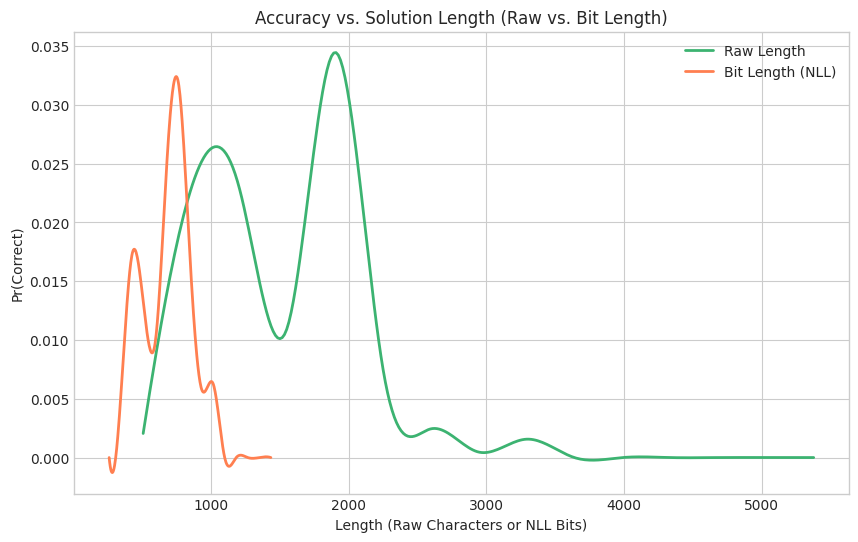

In [3]:
# --- Data Cleaning and Preparation ---

# Handle potential missing values for plotting
# Drop rows where accuracy or bit_length is null, or where code parsing failed
df_clean = df.dropna(subset=['is_correct', 'bit_length'])
df_clean = df_clean[df_clean['code_parse_error'] == False].copy() 

# Also remove rows where raw_length is 0 (likely indicates parsing issue or empty code)
df_clean = df_clean[df_clean['raw_length'] > 0].copy()

print(f"Shape after cleaning (removing nulls/errors/zero length): {df_clean.shape}")

# --- Binning and Averaging ---

# Choose the number of bins
num_bins = 15 # You can adjust this

# --- Raw Length Binning ---
# Create bins based on raw_length using pd.cut
# Use 'labels=False' to get bin indices, or omit for Interval labels
df_clean['raw_length_bin'] = pd.cut(df_clean['raw_length'], bins=num_bins, labels=False, include_lowest=True)
# Calculate the approximate midpoint of each bin for plotting
# Get bin edges first
raw_bin_edges = pd.cut(df_clean['raw_length'], bins=num_bins, include_lowest=True).cat.categories
raw_bin_midpoints = raw_bin_edges.mid

# Calculate average accuracy per raw length bin
raw_length_accuracy = df_clean.groupby('raw_length_bin', observed=False)['is_correct'].mean()
# Map bin indices back to midpoints for plotting
raw_plot_data = pd.DataFrame({
    'raw_length_mid': raw_bin_midpoints[raw_length_accuracy.index], # Use index of result
    'accuracy': raw_length_accuracy.values
}).sort_values('raw_length_mid') # Sort by length for plotting


# --- Bit Length Binning ---
# Create bins based on bit_length using pd.cut
df_clean['bit_length_bin'] = pd.cut(df_clean['bit_length'], bins=num_bins, labels=False, include_lowest=True)
# Calculate bin midpoints
bit_bin_edges = pd.cut(df_clean['bit_length'], bins=num_bins, include_lowest=True).cat.categories
bit_bin_midpoints = bit_bin_edges.mid

# Calculate average accuracy per bit length bin
bit_length_accuracy = df_clean.groupby('bit_length_bin', observed=False)['is_correct'].mean()
# Map bin indices back to midpoints for plotting
bit_plot_data = pd.DataFrame({
    'bit_length_mid': bit_bin_midpoints[bit_length_accuracy.index], # Use index of result
    'accuracy': bit_length_accuracy.values
}).sort_values('bit_length_mid') # Sort by length for plotting

print("\nRaw Length vs Accuracy (Binned):")
print(raw_plot_data)
print("\nBit Length vs Accuracy (Binned):")
print(bit_plot_data)


# --- Smoothing and Plotting ---
from scipy.interpolate import make_interp_spline

plt.figure(figsize=(10, 6))

# --- Plot Raw Length Curve ---
if not raw_plot_data.empty:
    # Define points for spline
    x_raw = raw_plot_data['raw_length_mid']
    y_raw = raw_plot_data['accuracy']
    
    # Create spline function (k=2 or k=3 for cubic)
    # Avoid issues if less than k+1 points
    k_raw = min(3, len(x_raw) - 1) if len(x_raw) > 1 else 1 
    if k_raw >= 1:
      spl_raw = make_interp_spline(x_raw, y_raw, k=k_raw)
      
      # Generate smooth x values for plotting
      x_raw_smooth = np.linspace(x_raw.min(), x_raw.max(), 300)
      y_raw_smooth = spl_raw(x_raw_smooth)
      
      # Plot smooth curve
      plt.plot(x_raw_smooth, y_raw_smooth, label='Raw Length', color='mediumseagreen', linewidth=2)
      # Optionally plot original binned points
      # plt.scatter(x_raw, y_raw, color='mediumseagreen', alpha=0.6)

# --- Plot Bit Length Curve ---
if not bit_plot_data.empty:
    # Define points for spline
    x_bit = bit_plot_data['bit_length_mid']
    y_bit = bit_plot_data['accuracy']
    
    # Create spline function
    k_bit = min(3, len(x_bit) - 1) if len(x_bit) > 1 else 1
    if k_bit >= 1:
      spl_bit = make_interp_spline(x_bit, y_bit, k=k_bit)
      
      # Generate smooth x values
      x_bit_smooth = np.linspace(x_bit.min(), x_bit.max(), 300)
      y_bit_smooth = spl_bit(x_bit_smooth)
      
      # Plot smooth curve
      plt.plot(x_bit_smooth, y_bit_smooth, label='Bit Length (NLL)', color='coral', linewidth=2)
      # Optionally plot original binned points
      # plt.scatter(x_bit, y_bit, color='coral', alpha=0.6)

# --- Final Plot Formatting ---
plt.xlabel('Length (Raw Characters or NLL Bits)')
plt.ylabel('Pr(Correct)') # Probability of Correctness (Mean Accuracy in Bin)
plt.title('Accuracy vs. Solution Length (Raw vs. Bit Length)')
plt.legend()
plt.grid(True)
# Optionally set y-axis limits if accuracy is very low
# plt.ylim(0, max(raw_plot_data['accuracy'].max(), bit_plot_data['accuracy'].max()) * 1.2) 
plt.show()


--- Correlation Analysis: Raw Length vs. Bit Length ---

Pearson Correlation Coefficient between raw_length and bit_length: 0.8231


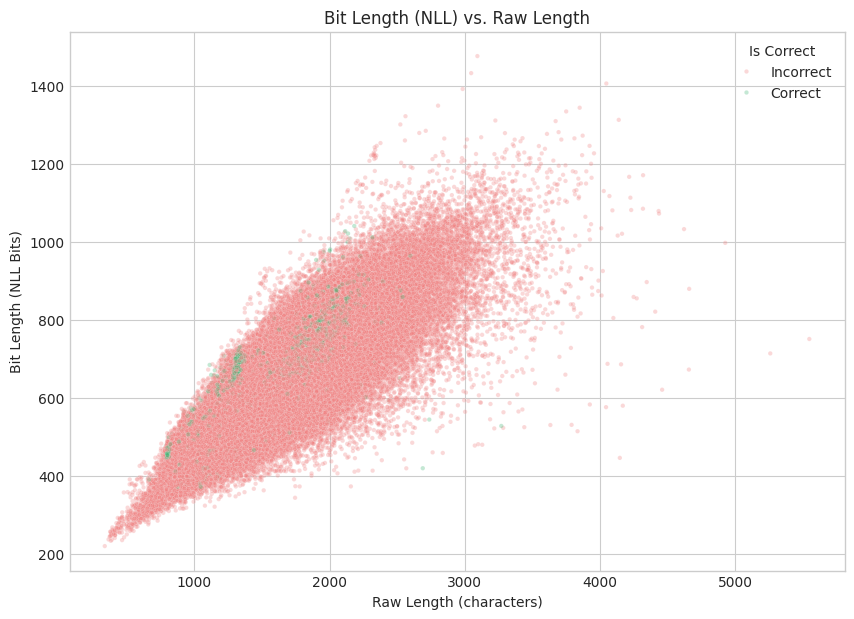

In [4]:
# --- Plot Correlation between Raw Length and Bit Length ---

print("\n--- Correlation Analysis: Raw Length vs. Bit Length ---")

# Calculate Pearson's correlation coefficient
# Ensure we are using the cleaned data where both lengths are non-null
correlation_matrix = df_clean[['raw_length', 'bit_length']].corr(method='pearson')
correlation_coefficient = correlation_matrix.loc['raw_length', 'bit_length']

print(f"\nPearson Correlation Coefficient between raw_length and bit_length: {correlation_coefficient:.4f}")

# Create the scatter plot
plt.figure(figsize=(10, 7))

# Use seaborn for potentially nicer plotting, use a sample if dataset is huge
# If df_clean is very large (100k+ points), plotting all points might be slow/dense.
# Consider plotting a random sample: df_sample = df_clean.sample(n=5000, random_state=42)
# Then use data=df_sample below. For now, using df_clean.
scatter_plot = sns.scatterplot(
    data=df_clean, 
    x='raw_length', 
    y='bit_length', 
    # Optionally add hue to see if correct/incorrect solutions differ
    hue='is_correct', 
    palette={0.0: 'lightcoral', 1.0: 'mediumseagreen', None: 'lightgrey'}, # Custom colors
    alpha=0.3, # Use transparency due to potentially many points
    s=10 # Adjust marker size
)

plt.title('Bit Length (NLL) vs. Raw Length')
plt.xlabel('Raw Length (characters)')
plt.ylabel('Bit Length (NLL Bits)')
# Adjust legend if hue is used
handles, labels = scatter_plot.get_legend_handles_labels()
# Map numeric labels back to meaningful names if needed, handle potential None
label_map = {'0.0': 'Incorrect', '1.0': 'Correct', 'nan': 'Unknown/Error'} 
new_labels = [label_map.get(lbl, lbl) for lbl in labels]
scatter_plot.legend(handles=handles, title='Is Correct', labels=new_labels)

plt.grid(True)
plt.show()


--- Analyzing Deviation between Normalized Lengths (using 101375 clean data points) ---
Selected 102 points with high deviation (below 0.00 or above 1.00 quantile).


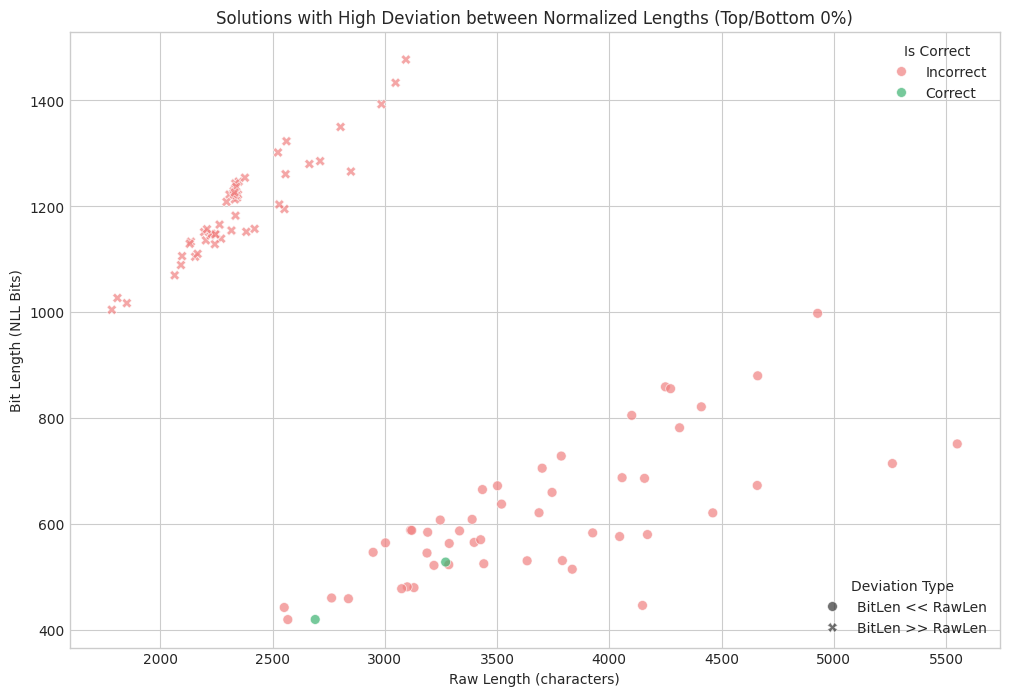


Stats for points where BitLength << RawLength (Normalized):
       is_correct   raw_length  bit_length
count   51.000000    51.000000   51.000000
mean     0.039216  3658.509804  612.571446
std      0.196039   670.494843  129.078200
min      0.000000  2552.000000  419.480933
25%      0.000000  3189.500000  526.529840
50%      0.000000  3502.000000  584.469729
75%      0.000000  4124.000000  679.509356
max      1.000000  5550.000000  997.823966

Stats for points where BitLength >> RawLength (Normalized):
       is_correct   raw_length   bit_length
count        51.0    51.000000    51.000000
mean          0.0  2351.901961  1197.511221
std           0.0   272.731902    95.239248
min           0.0  1784.000000  1004.523932
25%           0.0  2216.000000  1141.971870
50%           0.0  2327.000000  1203.473516
75%           0.0  2401.500000  1239.938065
max           0.0  3094.000000  1477.086500


In [10]:
# Make sure df_clean is available from the previous cell
# df_clean = df.dropna(subset=['is_correct', 'bit_length'])
# df_clean = df_clean[df_clean['code_parse_error'] == False]
# df_clean = df_clean[df_clean['raw_length'] > 0].copy()

from sklearn.preprocessing import MinMaxScaler
import numpy as np

print(f"\n--- Analyzing Deviation between Normalized Lengths (using {len(df_clean)} clean data points) ---")

# 1. Normalize Lengths to [0, 1] range
scaler = MinMaxScaler()
df_clean[['raw_length_scaled', 'bit_length_scaled']] = scaler.fit_transform(df_clean[['raw_length', 'bit_length']])

# 2. Calculate Deviation (Normalized Bit Length - Normalized Raw Length)
df_clean['length_deviation'] = df_clean['bit_length_scaled'] - df_clean['raw_length_scaled']

# 3. Filter for High Deviation Points
# Define deviation threshold using quantiles (e.g., bottom 10% and top 10%)
deviation_quantile = 0.0005
low_quantile = df_clean['length_deviation'].quantile(deviation_quantile)
high_quantile = df_clean['length_deviation'].quantile(1 - deviation_quantile)

df_deviating = df_clean[
    (df_clean['length_deviation'] <= low_quantile) | 
    (df_clean['length_deviation'] >= high_quantile)
].copy() # Select points in the tails of the deviation distribution

print(f"Selected {len(df_deviating)} points with high deviation (below {deviation_quantile:.2f} or above {1-deviation_quantile:.2f} quantile).")
# Add a column indicating direction of deviation for potential hue/style later
df_deviating['deviation_type'] = np.where(
    df_deviating['length_deviation'] <= low_quantile, 
    'BitLength << RawLength', 
    'BitLength >> RawLength'
)


# 4. Plot only the Deviating Points
plt.figure(figsize=(12, 8))

scatter_plot_dev = sns.scatterplot(
    data=df_deviating,
    x='raw_length',      # Use original length for x-axis interpretability
    y='bit_length',      # Use original length for y-axis interpretability
    hue='is_correct',    # Color by correctness
    style='deviation_type', # Optional: Use different markers for direction of deviation
    palette={0.0: 'lightcoral', 1.0: 'mediumseagreen', None: 'lightgrey'},
    alpha=0.7,           # Slightly less transparency now
    s=50                 # Slightly larger markers
)

plt.title(f'Solutions with High Deviation between Normalized Lengths (Top/Bottom {deviation_quantile*100:.0f}%)')
plt.xlabel('Raw Length (characters)')
plt.ylabel('Bit Length (NLL Bits)')

# Adjust legend
handles, labels = scatter_plot_dev.get_legend_handles_labels()
# Customize labels (handle potential None in is_correct)
label_map = {'0.0': 'Incorrect', '1.0': 'Correct', 'nan': 'Unknown/Error', 
             'BitLength << RawLength': 'BitLen << RawLen', 'BitLength >> RawLength': 'BitLen >> RawLen'} 
new_labels = [label_map.get(lbl, lbl) for lbl in labels]
# Separate legends for hue and style might be clearer
# plt.legend(title='Is Correct / Deviation Type') # Auto legend
# Or create separate legends if needed

# Manually create legends for clarity
hue_handles = [h for h, l in zip(handles, labels) if l in ['0.0', '1.0', 'nan']]
hue_labels = [label_map.get(l, l) for l in labels if l in ['0.0', '1.0', 'nan']]
style_handles = [h for h, l in zip(handles, labels) if l in ['BitLength << RawLength', 'BitLength >> RawLength']]
style_labels = [label_map.get(l, l) for l in labels if l in ['BitLength << RawLength', 'BitLength >> RawLength']]

legend1 = plt.legend(hue_handles, hue_labels, title="Is Correct", loc='upper right')
plt.gca().add_artist(legend1) # Add the first legend
if style_handles: # Only add second legend if style was used and generated handles
     plt.legend(style_handles, style_labels, title="Deviation Type", loc='lower right')


plt.grid(True)
plt.show()

# Optional: Print statistics for the deviating points
print("\nStats for points where BitLength << RawLength (Normalized):")
print(df_deviating[df_deviating['deviation_type'] == 'BitLength << RawLength'][['is_correct', 'raw_length', 'bit_length']].describe())

print("\nStats for points where BitLength >> RawLength (Normalized):")
print(df_deviating[df_deviating['deviation_type'] == 'BitLength >> RawLength'][['is_correct', 'raw_length', 'bit_length']].describe())


--- Normalized Cumulative Accuracy vs. Length Analysis ---
Total correct solutions found: 1865.0


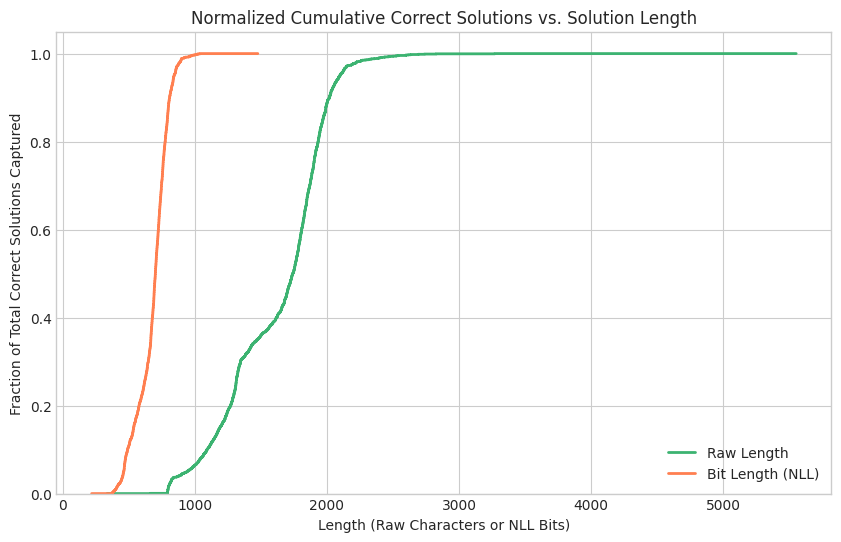

In [13]:
# Make sure df_clean is available from the previous cell
# df_clean = df.dropna(subset=['is_correct', 'bit_length'])
# df_clean = df_clean[df_clean['code_parse_error'] == False]
# df_clean = df_clean[df_clean['raw_length'] > 0].copy()

print("\n--- Normalized Cumulative Accuracy vs. Length Analysis ---")

# Calculate total number of correct solutions
total_correct_solutions = df_clean['is_correct'].sum()
print(f"Total correct solutions found: {total_correct_solutions}")

if total_correct_solutions > 0:
    # --- Prepare Data for Cumulative Plots ---

    # 1. Sort data by Raw Length & Calculate Cumulative Correct
    df_sorted_raw = df_clean.sort_values('raw_length').copy()
    df_sorted_raw['cumulative_correct'] = df_sorted_raw['is_correct'].cumsum()
    # Calculate normalized cumulative correct
    df_sorted_raw['norm_cumulative_correct'] = df_sorted_raw['cumulative_correct'] / total_correct_solutions

    # 2. Sort data by Bit Length & Calculate Cumulative Correct
    df_sorted_bit = df_clean.sort_values('bit_length').copy()
    df_sorted_bit['cumulative_correct'] = df_sorted_bit['is_correct'].cumsum()
    # Calculate normalized cumulative correct
    df_sorted_bit['norm_cumulative_correct'] = df_sorted_bit['cumulative_correct'] / total_correct_solutions

    # --- Create Normalized Cumulative Plot ---
    plt.figure(figsize=(10, 6))

    # Plot Normalized Cumulative Correct vs. Raw Length
    if not df_sorted_raw.empty:
        plt.plot(
            df_sorted_raw['raw_length'],
            df_sorted_raw['norm_cumulative_correct'], # Use normalized column
            label='Raw Length',
            color='mediumseagreen',
            linewidth=2
        )

    # Plot Normalized Cumulative Correct vs. Bit Length
    if not df_sorted_bit.empty:
        plt.plot(
            df_sorted_bit['bit_length'],
            df_sorted_bit['norm_cumulative_correct'], # Use normalized column
            label='Bit Length (NLL)',
            color='coral',
            linewidth=2
        )

    # --- Final Plot Formatting ---
    plt.xlabel('Length (Raw Characters or NLL Bits)')
    plt.ylabel('Fraction of Total Correct Solutions Captured')
    plt.title('Normalized Cumulative Correct Solutions vs. Solution Length')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05) # Set y-axis limit 0 to ~1
    plt.show()

else:
    print("No correct solutions found in the dataset. Cannot generate normalized cumulative plot.")